In [39]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [40]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [41]:
# split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [42]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10, 7))

    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="predictions")

    plt.legend(prop={"size": 14})

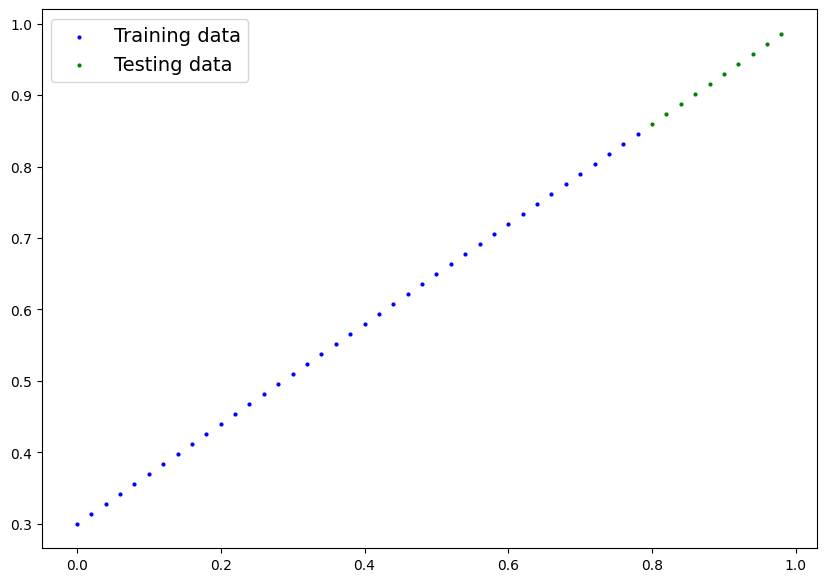

In [43]:
plot_predictions(X_train, y_train, X_test, y_test)

In [44]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # self.weight = nn.Parameter(torch.randn(1, requires_grad=True))
        # self.bias = nn.Parameter(torch.randn(1, requires_grad=True))

        # use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    # def forward(self, x: torch.Tensor) -> torch.Tensor:
    #     return self.weight * x + self.bias

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
torch.manual_seed(42)
model = LinearRegressionModel()
model, model.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
next(model.parameters()).device

device(type='cpu')

In [46]:
# trainning
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [47]:
torch.manual_seed(42)

epochs = 200

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []


# put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model.train()

    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)
    
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")


Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.4399680495262146 | Test loss: 0.4392663538455963
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954827964305878 | Test loss: 0.16984674334526062
Epoch: 40 | Loss: 0.09433844685554504 | Test loss: 0.03513689711689949
Epoch: 50 | Loss: 0.023886386305093765 | Test loss: 0.04784906655550003
Epoch: 60 | Loss: 0.0199567973613739 | Test loss: 0.04580312222242355
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.0375305712223053
Epoch: 80 | Loss: 0.013089170679450035 | Test loss: 0.029944902285933495
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215679459273815 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.002787243574857712 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.01380180753767

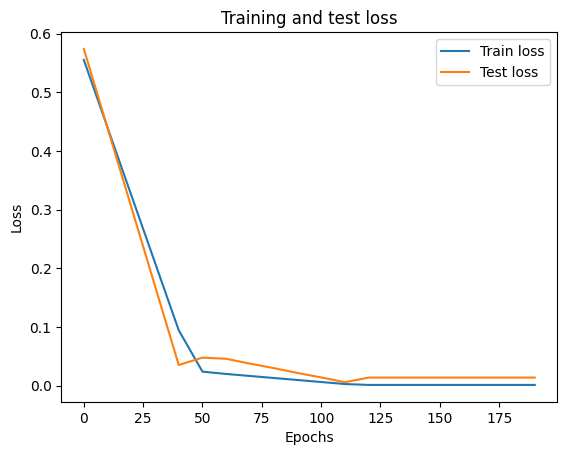

In [48]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [49]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [50]:
weight, bias

(0.7, 0.3)

In [51]:
model.eval()
with torch.inference_mode():
    y_preds = model(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

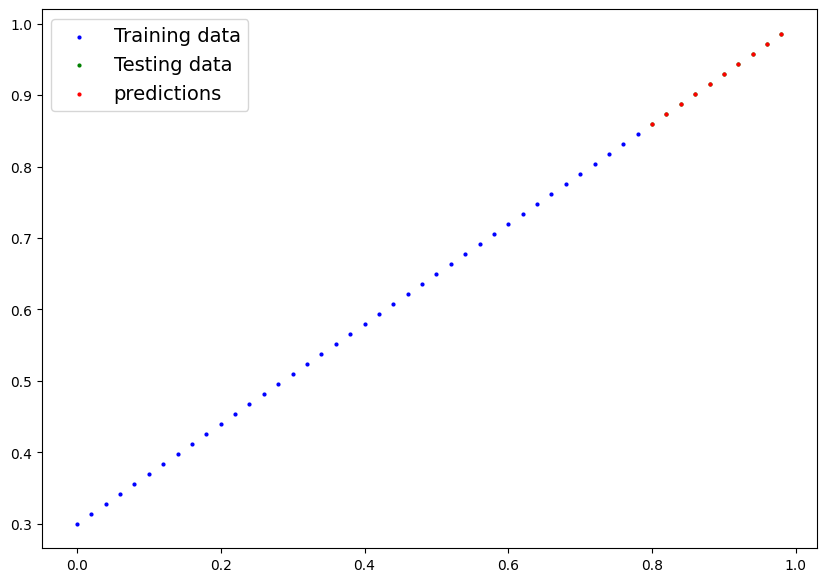

In [52]:
plot_predictions(predictions=y_preds.cpu())

In [53]:
# saving and loading a trained model
from pathlib import Path
model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "pytorch_workflow_model.pth"
model_save_path = model_path / model_name

print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), f=model_save_path)

Saving model to: models\pytorch_workflow_model.pth


In [54]:
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(model_save_path))

loaded_model.to(device)


LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [55]:
loaded_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [56]:
loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])